In [8]:
import numpy as np 
import pandas as pd
import csv 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
import os 
os.chdir("/Users/susanchen/Documents/GitHub/skincare_classification/Plots")
from collections import Counter 
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, cross_val_score, GridSearchCV, train_test_split
import ast
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras.wrappers.scikit_learn import KerasClassifier 

## Building Multi-label Classifiers 
### Base Classifiers to test: Binary Relevance (no correlation), Binary Relevance (with correlation), Multi-label Random Forest, Multi-label Decision Tree, Classifier Chain, Binary Releveance with Stacking Aggregation, Cross-Coupling Aggregation (to combat class-imbalances)

In [9]:
data = pd.read_csv('/Users/susanchen/Documents/GitHub/skincare_classification/Data_sets/Master_cleaned.csv')

In [10]:
data

,Product,Brand,Ingredients,Price,Skin_Type,Combination,Dry,Normal,Oily,Sensitive,...,num_of_Emollients,num_of_Hydration,num_of_Skin-Restoring,num_of_Plant Extracts,num_of_Preservatives,num_of_Skin-Softening,num_of_Sensitizing,num_of_Skin-Replenishing,top_3,top3_category_list
0,#InstantDetox Facial Mask,Biobelle,"Water, Butylene Glycol, Glycerin, Trehalose, H...",3.99,['Oily'],0,0,0,1,0,...,0,0,0,0,0,0,0,1,"['Butylene Glycol', 'Glycerin', 'Trehalose']","['Texture Enhancer', 'Skin-Replenishing, Skin-..."
1,#Peachy Facial Mask,Biobelle,"Water, Methylpropanediol, Butylene Glycol, Gly...",3.99,['Dry'],0,1,0,0,0,...,0,0,0,0,0,0,0,1,"['Methylpropanediol', 'Butylene Glycol', 'Glyc...","[None, 'Texture Enhancer', 'Skin-Replenishing,..."
2,#Rise&Shine Facial Mask,Biobelle,"Water, Glycerin, Butylene Glycol, Triethylhexa...",3.99,['Combination'],1,0,0,0,0,...,0,0,0,0,0,0,0,1,"['Glycerin', 'Butylene Glycol', 'Triethylhexan...","['Skin-Replenishing, Skin-Restoring', 'Texture..."
3,#RoséAllDay Facial Mask,Biobelle,"Water, Methylpropanediol, Glycerin, Propanedio...",3.99,['Combination'],1,0,0,0,0,...,0,0,0,1,2,0,0,2,"['Methylpropanediol', 'Glycerin', 'Propanediol']","[None, 'Skin-Replenishing, Skin-Restoring', None]"
4,#VitaminSea Facial Mask,Biobelle,"Water, Butylene Glycol, Glycerin, Hydroxyaceto...",3.99,['Dry'],0,1,0,0,0,...,0,0,0,1,0,0,0,1,"['Butylene Glycol', 'Glycerin', 'Hydroxyacetop...","['Texture Enhancer', 'Skin-Replenishing, Skin-..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,Youthful Vitamin C Fresh Radiance Essence,No7,"Aqua (Water), Butylene Glycol, Glycerin, Gluco...",24.99,"['Combination', 'Dry', 'Normal', 'Oily']",1,1,1,1,0,...,0,0,0,2,3,0,0,2,"['Butylene Glycol', 'Glycerin', 'Gluconolactone']","['Texture Enhancer', 'Skin-Replenishing, Skin-..."
2020,Yuza Sorbet Day Cream,Erborian,"Aqua/Water, Cyclomethicone, Glycerin, Nylon-12...",48.00,"['Combination', 'Dry', 'Normal', 'Oily', 'Sens...",1,1,1,1,1,...,1,0,0,1,1,0,0,1,"['Cyclomethicone', 'Glycerin', 'Nylon-12']","['Emollients', 'Skin-Replenishing, Skin-Restor..."
2021,Yuza Sorbet Night Treatment,Erborian,"Aqua/Water, Cyclomethicone, Glycerin, Cetearyl...",55.00,"['Combination', 'Dry', 'Normal', 'Oily', 'Sens...",1,1,1,1,1,...,2,0,0,0,0,0,0,1,"['Cyclomethicone', 'Glycerin', 'Cetearyl Alcoh...","['Emollients', 'Skin-Replenishing, Skin-Restor..."
2022,Yuzu Overnight Moisture Mask,Earth Therapeutics,"Water (Aqua), Propanediol, Glycerin, Hydrogena...",7.00,"['Combination', 'Dry', 'Normal', 'Sensitive']",1,1,1,0,1,...,2,0,0,1,0,0,0,1,"['Propanediol', 'Glycerin', 'Hydrogenated Poly...","[None, 'Skin-Replenishing, Skin-Restoring', None]"


In [11]:
from sklearn.model_selection import train_test_split
# remove classes with less than 4 observations 
data = data[data.Skin_Type != "['Oily', 'Sensitive']"]
data = data[data.Skin_Type != "['Dry', 'Normal', 'Oily']"]
data = data[data.Skin_Type != "['Dry', 'Oily']"]
data = data[data.Skin_Type != "['Dry', 'Normal', 'Oily', 'Sensitive']"]
data = data[data.Skin_Type != "['Combination', 'Dry', 'Oily', 'Sensitive']"]
data = data[data.Skin_Type != "['Normal', 'Oily']"]

X = data[data.columns[17:28]].values
y = data.Skin_Type
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state = 1024, stratify=y)

print("Dataset sizes:\n\tTrain %s\n\tTest %s" % (X_train.shape,X_test.shape))

Dataset sizes:
	Train (1407, 11)
	Test (603, 11)


In [12]:
y_train = y_train.apply(ast.literal_eval)
y_test = y_test.apply(ast.literal_eval)

mlb=MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
mlb.classes_

array(['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive'], dtype=object)

## Baseline 


In [13]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy= 'uniform', random_state=1024)
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)


0.029850746268656716

In [14]:
p = dummy.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(y_test,p))
print("F1 Score = ", metrics.f1_score(y_test,p, average = "weighted"))
print("Hamming Loss", metrics.hamming_loss(y_test, p))


Accuracy =  0.029850746268656716
F1 Score =  0.5882546298802469
Hamming Loss 0.5058043117744611


## Problem Transformation Methods

In [15]:
kf = KFold(n_splits=5, shuffle = True, random_state=1024)
ham_loss = metrics.make_scorer(metrics.hamming_loss, greater_is_better= False)
mlb2 = MultiLabelBinarizer()
y = mlb2.fit_transform(y)

def grid_search (model, search_space):
    pipe = Pipeline([("classifier", model)])
    gs = GridSearchCV(pipe, search_space, scoring = "accuracy", cv= kf)
    gs.fit(X_train, y_train)
    return gs.best_estimator_.get_params()["classifier"]


In [16]:
def get_cross_val_results (clf, base_classifier, X, y, X_test,y_test):
    try: 
        model = clf(classifier = best_classifier)
    except TypeError:
        model = clf(base_classifier = best_classifier)
    results = cross_validate(model, X, y, cv= kf, scoring =('accuracy', "f1_weighted"), return_train_score = True)
    # train results 
    train_accuracy = results['train_accuracy'].mean()
    train_f1 = results['train_f1_weighted']
    print(model)
    print("Training Accuracy = %.04f +/- %.04f" % (train_accuracy.mean(), train_accuracy.std()*2))
    print("Training F1 Score = %.04f +/- %.04f" % (train_f1.mean(), train_f1.std()*2))

    # test results
    y_pred = cross_val_predict(model, X_test, y_test, cv=kf)
    test_accuracy = results['test_accuracy'].mean()
    test_f1 = results['test_f1_weighted']
    print("Test Accuracy = %.04f +/- %.04f" % (test_accuracy.mean(), test_accuracy.std()*2))
    print("Test F1 Score = %.04f +/- %.04f" % (test_f1.mean(), test_f1.std()*2))
    print("Hamming Loss = %.04f" % metrics.hamming_loss(y_test, y_pred))

### One vs the Rest Classifier (Binary Relevance)

In [17]:
search_space1 = [{'classifier':[DecisionTreeClassifier()], 'classifier__max_depth' :[5,6,7,8,9],
    'classifier__max_leaf_nodes': [5,6,7,8,9,10,15]},{'classifier': [RandomForestClassifier()], 'classifier__n_estimators': [5,8,10,12,14,15],'classifier__max_features': [[8,9,10,11], "auto", 'sqrt', 'log2']}, {'classifier': [SVC()], 'classifier__kernel':['rbf', 'linear']},{'classifier': [MultinomialNB()], 'classifier__alpha': [.7, 1.0]}]

In [18]:
best_classifier = grid_search(BinaryRelevance(), search_space1)
get_cross_val_results(BinaryRelevance, best_classifier, X_train, y_train, X_test, y_test)

BinaryRelevance(classifier=DecisionTreeClassifier(max_depth=5,
                                                  max_leaf_nodes=5),
                require_dense=[True, True])
Training Accuracy = 0.4446 +/- 0.0000
Training F1 Score = 0.8525 +/- 0.0046
Test Accuracy = 0.4186 +/- 0.0000
Test F1 Score = 0.8457 +/- 0.0181
Hamming Loss = 0.2779


In [19]:
from sklearn.multiclass import OneVsRestClassifier
classif = OneVsRestClassifier(SVC(kernel='linear', random_state= 1024))
classif.fit(X_train, y_train)
val_pred = classif.predict(X_val)
# accuracy
print("Accuracy = ", metrics.accuracy_score(y_val, val_pred))
print("F1 Score = ", metrics.f1_score(y_val,val_pred, average = "micro"))
print("Hamming Loss", metrics.hamming_loss(y_val, val_pred))

NameError: name 'X_val' is not defined

#### Classifier Chains 

In [1]:
best_classifier = grid_search(ClassifierChain(), search_space1)
get_cross_val_results(ClassifierChain, best_classifier, X_train, y_train, X_test, y_test)

NameError: name 'grid_search' is not defined

### Label Powerset


In [17]:
best_classifier = grid_search(LabelPowerset(), search_space1)
get_cross_val_results(LabelPowerset,best_classifier, X_train, y_train, X_test, y_test)


LabelPowerset(classifier=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=5),
              require_dense=[True, True])
Training Accuracy = 0.4595 +/- 0.0000
Training F1 Score = 0.8517 +/- 0.0042
Test Accuracy = 0.4542 +/- 0.0000
Test F1 Score = 0.8512 +/- 0.0176
Hamming Loss = 0.2713


## Ensemble Methods

### Random Forest Classifier 

In [19]:
def rfc_grid_search(model, hyperparameters):
    gs = GridSearchCV(model, hyperparameters, scoring = ham_loss, cv= kf)
    gs.fit(X_train, y_train)
    return gs.best_estimator_.get_params()

In [20]:
model4 = RandomForestClassifier(random_state = 1024)
hyperparameters = {'n_estimators' :[4,5,8,10,15,20], "criterion" :['gini', 'entropy'], 'max_leaf_nodes': [5,6,7,8,9,10,15], 'max_features': [8,9,10,11]}
best_param = rfc_grid_search(model4, hyperparameters)

In [21]:
best_param

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 11,
 'max_leaf_nodes': 15,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1024,
 'verbose': 0,
 'warm_start': False}

In [208]:
model4 = RandomForestClassifier(bootstrap= True, criterion= "entropy", max_features= 8, max_leaf_nodes= 15, n_estimators=10,random_state=1024)

# train results
results = cross_validate(model4, X_train, y_train, cv= kf, scoring =('accuracy', "f1_weighted"), return_train_score = True)
train_accuracy = results['train_accuracy'].mean()
train_f1 = results['train_f1_weighted']
print("Training Accuracy = %.04f +/- %.04f" % (train_accuracy.mean(), train_accuracy.std()*2))
print("Training F1 Score = %.04f +/- %.04f" % (train_f1.mean(), train_f1.std()*2))

# test results
y_pred = cross_val_predict(model4, X_test, y_test, cv=kf)
test_accuracy = results['test_accuracy']
test_f1 = results['test_f1_weighted']
print("Test Accuracy = %.04f +/- %.04f" % (test_accuracy.mean(), test_accuracy.std()*2))
print("Test F1 Score = %.04f +/- %.04f" % (test_f1.mean(), test_f1.std()*2))
print("Hamming Loss = %.04f" % (metrics.hamming_loss(y_test, y_pred)))

Training Accuracy = 0.4451 +/- 0.0000
Training F1 Score = 0.8547 +/- 0.0062
Test Accuracy = 0.4165 +/- 0.0619
Test F1 Score = 0.8464 +/- 0.0208
Hamming Loss = 0.2806


### RAkELd: random label space partitioning with Label powerset 

In [20]:
from skmultilearn.ensemble import RakelD
get_cross_val_results(RakelD, SVC(kernel='linear', random_state= 1024), X_train, y_train, X_test, y_test)

RakelD(base_classifier=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=5))
Training Accuracy = 0.4579 +/- 0.0000
Training F1 Score = 0.8521 +/- 0.0039
Test Accuracy = 0.4485 +/- 0.0000
Test F1 Score = 0.8502 +/- 0.0179
Hamming Loss = 0.2716


## Synthetic Minority Oversampling Technique (SMOTE)
### Use SMOTE to oversample the minority classes. 

In [7]:
data = pd.read_csv('/Users/susanchen/Documents/GitHub/skincare_classification/Data_sets/Master_cleaned.csv')
# remove classes with less than 4 observations 
data = data[data.Skin_Type != "['Oily', 'Sensitive']"]
data = data[data.Skin_Type != "['Dry', 'Normal', 'Oily']"]
data = data[data.Skin_Type != "['Dry', 'Oily']"]
data = data[data.Skin_Type != "['Dry', 'Normal', 'Oily', 'Sensitive']"]
data = data[data.Skin_Type != "['Combination', 'Dry', 'Oily', 'Sensitive']"]
data = data[data.Skin_Type != "['Normal', 'Oily']"]

X = data[data.columns[17:28]].values
y = data.Skin_Type

#summarize class distribution 
counter = Counter(y)
print(counter)

Counter({"['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']": 918, "['Combination', 'Dry', 'Normal', 'Oily']": 239, "['Combination', 'Normal', 'Oily']": 113, "['Combination', 'Oily']": 91, "['Normal']": 83, "['Dry', 'Normal']": 72, "['Dry']": 71, "['Combination', 'Dry', 'Normal']": 66, "['Combination', 'Dry', 'Normal', 'Sensitive']": 61, "['Combination']": 59, "['Sensitive']": 46, "['Combination', 'Normal']": 30, "['Dry', 'Normal', 'Sensitive']": 29, "['Oily']": 26, "['Combination', 'Normal', 'Oily', 'Sensitive']": 23, "['Combination', 'Dry']": 22, "['Dry', 'Sensitive']": 19, "['Combination', 'Dry', 'Oily']": 13, "['Normal', 'Sensitive']": 12, "['Combination', 'Oily', 'Sensitive']": 10, "['Combination', 'Dry', 'Sensitive']": 7})


In [8]:
#SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state = 1024, stratify=y)
num = 100
num2 = 50

# summarize the class distribution
counter = Counter(y_train)
print("Before resampling:") 
print (counter)

oversample = SMOTE(k_neighbors = 3, sampling_strategy = {"['Combination', 'Normal', 'Oily']": num, "['Combination', 'Oily']": num, "['Dry']": num, "['Normal']": num, "['Combination', 'Dry', 'Normal', 'Sensitive']": num, "['Dry', 'Normal']": num, "['Combination', 'Dry', 'Normal']": num, "['Combination']": num, "['Sensitive']": num2, "['Combination', 'Normal']": num2, "['Dry', 'Normal', 'Sensitive']": num2, "['Dry', 'Sensitive']": num2, "['Combination', 'Dry']": num2, "['Oily']": num2, "['Combination', 'Normal', 'Oily', 'Sensitive']": num2, "['Combination', 'Dry', 'Oily']": num2, "['Normal', 'Sensitive']": num2, "['Combination', 'Oily', 'Sensitive']": num2, "['Combination', 'Dry', 'Sensitive']": num2})
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train)
print( )
print("After Oversampling:") 
print(counter)

#undersample = RandomUnderSampler(sampling_strategy={"['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']": 500})
#X_train, y_train = undersample.fit_resample(X_train, y_train)
#counter = Counter(y_train)
#print( )
#print("After Undersampling:") 
#print(counter)

Before resampling:
Counter({"['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']": 643, "['Combination', 'Dry', 'Normal', 'Oily']": 167, "['Combination', 'Normal', 'Oily']": 79, "['Combination', 'Oily']": 64, "['Normal']": 58, "['Dry', 'Normal']": 50, "['Dry']": 50, "['Combination', 'Dry', 'Normal']": 46, "['Combination', 'Dry', 'Normal', 'Sensitive']": 43, "['Combination']": 41, "['Sensitive']": 32, "['Combination', 'Normal']": 21, "['Dry', 'Normal', 'Sensitive']": 20, "['Oily']": 18, "['Combination', 'Dry']": 16, "['Combination', 'Normal', 'Oily', 'Sensitive']": 16, "['Dry', 'Sensitive']": 13, "['Combination', 'Dry', 'Oily']": 9, "['Normal', 'Sensitive']": 9, "['Combination', 'Oily', 'Sensitive']": 7, "['Combination', 'Dry', 'Sensitive']": 5})

After Oversampling:
Counter({"['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']": 643, "['Combination', 'Dry', 'Normal', 'Oily']": 167, "['Normal']": 100, "['Combination', 'Dry', 'Normal', 'Sensitive']": 100, "['Combination']": 100, "['C

In [9]:
print("Dataset sizes:\n\tTrain %s\n\tTest %s" % (X_train.shape, X_test.shape))

Dataset sizes:
	Train (2160, 11)
	Test (603, 11)


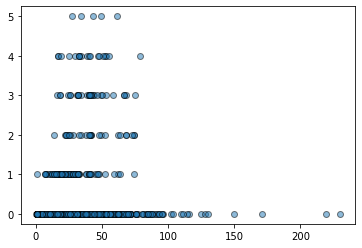

In [217]:
plot = plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, edgecolor='k')


In [10]:
y_train = y_train.apply(ast.literal_eval)
y_test = y_test.apply(ast.literal_eval)

mlb=MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
mlb.classes_

array(['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive'], dtype=object)

## Results after running SMOTE

In [16]:
clf = [BinaryRelevance, ClassifierChain, LabelPowerset]
for classifier in clf:
    best_classifier = grid_search(classifier(), s)
    get_results(classifier,best_classifier, X_train, y_train, X_test, y_test)


BinaryRelevance(classifier=RandomForestClassifier(n_estimators=15),
                require_dense=[True, True])
Training Accuracy = 0.8788 +/- 0.0000
Training F1 Score = 0.9692 +/- 0.0023
Test Accuracy = 0.3630 +/- 0.0000
Test F1 Score = 0.8066 +/- 0.0169
Hamming Loss = 0.2909
ClassifierChain(classifier=RandomForestClassifier(max_features='sqrt',
                                                  n_estimators=15),
                require_dense=[True, True])
Training Accuracy = 0.9060 +/- 0.0000
Training F1 Score = 0.9661 +/- 0.0013
Test Accuracy = 0.4384 +/- 0.0000
Test F1 Score = 0.8066 +/- 0.0181
Hamming Loss = 0.2846
LabelPowerset(classifier=RandomForestClassifier(max_features='log2',
                                                n_estimators=15),
              require_dense=[True, True])
Training Accuracy = 0.9211 +/- 0.0000
Training F1 Score = 0.9698 +/- 0.0025
Test Accuracy = 0.4366 +/- 0.0000
Test F1 Score = 0.7955 +/- 0.0189
Hamming Loss = 0.2992


In [24]:
rfc_SMOTE = RandomForestClassifier(random_state = 1024)
best_param = rfc_grid_search(rfc_SMOTE, hyperparameters)

In [25]:
best_param

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 11,
 'max_leaf_nodes': 15,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1024,
 'verbose': 0,
 'warm_start': False}

In [29]:
rfc_SMOTE = RandomForestClassifier(bootstrap= True, criterion= "entropy", max_features= 11, max_leaf_nodes= 15, n_estimators=10,random_state=1024)
kf = KFold(n_splits=5, random_state=1024)
# train results
results = cross_validate(rfc_SMOTE, X_train, y_train, cv= kf, scoring =('accuracy', "f1_weighted"), return_train_score = True)
train_accuracy = results['train_accuracy'].mean()
train_f1 = results['train_f1_weighted']
print("Training Accuracy = %.04f +/- %.04f" % (train_accuracy.mean(), train_accuracy.std()*2))
print("Training F1 Score = %.04f +/- %.04f" % (train_f1.mean(), train_f1.std()*2))

# test results
y_pred = cross_val_predict(rfc_SMOTE, X_test, y_test, cv=kf)
test_accuracy = results['test_accuracy']
test_f1 = results['test_f1_weighted']
print("Test Accuracy = %.04f +/- %.04f" % (test_accuracy.mean(), test_accuracy.std()*2))
print("Test F1 Score = %.04f +/- %.04f" % (test_f1.mean(), test_f1.std()*2))
print("Hamming Loss = %.04f" % (metrics.hamming_loss(y_test, y_pred)))

Training Accuracy = 0.2485 +/- 0.0000
Training F1 Score = 0.7841 +/- 0.0610
Test Accuracy = 0.1727 +/- 0.2200
Test F1 Score = 0.7443 +/- 0.2424
Hamming Loss = 0.2846


## Adaptative Methods

###  Multi-label K Nearest Neighbors

In [62]:
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import BRkNNaClassifier
import time

parameters = {'k': range(1,3), 
              's': [0.5, 0.7, 1.0]}

score = ham_loss

start=time.time()

classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
classifier.fit(X_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_, 'best score: ',
      classifier.best_score_)

training time taken:  36.0 seconds
best parameters : {'k': 2, 's': 0.5} best score:  -0.32981481481481484


### Binary Relevance K-Nearest Neighbors

In [63]:
parameters = {'k': range(3,5)}
start=time.time()

classifier = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score)
classifier.fit(X_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_,
      'best score: ',classifier.best_score_)


training time taken:  2.0 seconds
best parameters : {'k': 3} best score:  -0.35083333333333333


In [65]:
BrKnn = BRkNNaClassifier(k= 3)
BrKnn.fit(X_train, y_train)
pred = BrKnn.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred, average='weighted'))

0.23509933774834438
0.7505151884141751


## Neural Network

In [108]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
import keras as Keras
from keras.regularizers import l2



Epoch 1/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5788 - accuracy: 0.1166 - val_loss: 0.5641 - val_accuracy: 0.0779
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 0.5687 - accuracy: 0.1798 - val_loss: 0.5588 - val_accuracy: 0.2504
Epoch 3/200
71/71 [==============================] - 0s 2ms/step - loss: 0.5653 - accuracy: 0.2139 - val_loss: 0.5593 - val_accuracy: 0.4444
Epoch 4/200
71/71 [==============================] - 0s 3ms/step - loss: 0.5626 - accuracy: 0.2303 - val_loss: 0.5580 - val_accuracy: 0.4859
Epoch 5/200
71/71 [==============================] - 0s 3ms/step - loss: 0.5606 - accuracy: 0.3930 - val_loss: 0.5544 - val_accuracy: 0.4726
Epoch 6/200
71/71 [==============================] - 0s 2ms/step - loss: 0.5596 - accuracy: 0.2829 - val_loss: 0.5521 - val_accuracy: 0.2471
Epoch 7/200
71/71 [==============================] - 0s 3ms/step - loss: 0.5566 - accuracy: 0.2864 - val_loss: 0.5515 - val_accuracy: 0.3466
Epoch 8/200
7

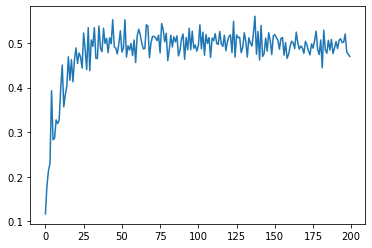

In [117]:
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer ="random_uniform", activation = 'relu'))

model.add(Dense(y_train.shape[1], activation ='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer = 'adam', metrics =['accuracy'])
hist = model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=200, batch_size = 20)
results = model.evaluate(X_test, y_test, verbose = 0)
plt.plot(hist.history["accuracy"])
plt.show()

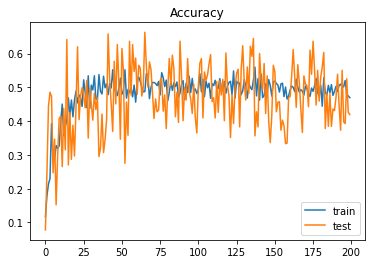

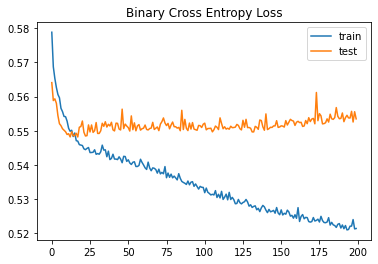

In [118]:
#plot accuracy 
plt.subplot()
plt.title("Accuracy")
plt.plot(hist.history["accuracy"], label = 'train')
plt.plot(hist.history["val_accuracy"], label = 'test')
plt.legend()
plt.show()

#plot loss
plt.subplot()
plt.title("Binary Cross Entropy Loss")
plt.plot(hist.history["loss"], label = 'train')
plt.plot(hist.history["val_loss"], label = 'test')
plt.legend()
plt.show()

In [125]:
np.random.seed(1024)
def create_network(X_train, y_train):
    network = Sequential()
    #hidden layer
    network.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer ="random_uniform", activation = 'relu'))
    #network.add(Dense(20, activation = 'relu', kernel_regularizer = l2(.01)))
    #output layer
    network.add(Dense(y_train.shape[1], activation ='sigmoid'))
    network.compile(loss="binary_crossentropy", 
                    optimizer = 'adam', 
                    metrics =['accuracy'])
    return network 


In [1]:
neural_network = KerasClassifier(build_fn=create_network, epochs =10, batch_size = 100, verbose =0)
cross_val_score(neural_network, X_train, y_train, cv =kf).mean()

NameError: name 'KerasClassifier' is not defined

In [7]:
#wrapper 
neural_network = KerasClassifier(build_fn=create_network, epochs = 200, batch_size = 20, verbose = 0)

#grid search 
param_space = dict(epochs = [50, 100, 150, 200])
grid_results = GridSearchCV(neural_network, param_grid= param_space, cv = kf)

#evaluate neural network with 5-fold cross-validation 
cross_val_score(neural_network, X_train, y_train, cv =kf).mean()


NameError: name 'KerasClassifier' is not defined

In [1312]:

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)